In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.integrate import simpson
from tqdm import tqdm
import pickle

In [2]:
common_settings = {
'perturbations_verbose':0,
'background_verbose':0,
'output':'mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':300,
'z_max_pk':1000,
'format':'class'
}

chiCDM = Class()
# pass input parameters
chiCDM.set(common_settings)
chiCDM.set({
'omega_cdm':0.11,
'f_chi':1.e-10 ,
'acs_chi':1.e-7,
'cs2_peak_chi':1./3.,

})

chiCDM.compute()

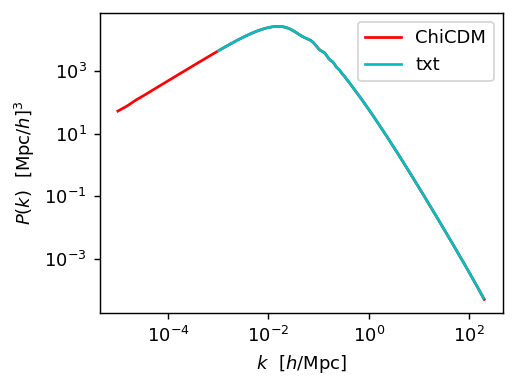

In [3]:
from scipy.interpolate import interp1d
fact=(2*np.pi)**3

kk = np.logspace(-5,np.log10(200),500) # k in h/Mpc
Pkchi = [] # P(k) in (Mpc/h)**3
h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc

lowz=0.

for k in kk:
    Pkchi.append(chiCDM.pk_lin(k*h,lowz)*h**3) # function .pk(k,z)
Pkchi=np.array(Pkchi)

Pchi_int = interp1d(kk, Pkchi, fill_value='extrapolate')
# with open('/home/fverdian/class/soundspeed-scripts/1loop/Pk-lin-int.pkl', 'wb') as f:
#     pickle.dump(Pchi_int, f)

plt.figure(figsize=(4,3), dpi=130)
plt.xscale('log');plt.yscale('log');
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')


plt.plot(kk,Pkchi,'r-',label=r'ChiCDM')

plt.plot(kk[:-1]+1.e-3,Pchi_int(kk[:-1]+1.e-3),'c-',label=r'txt')


plt.legend()
plt.show()

---
### Compute P22

P13

In [4]:
def F2(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    return (k2*(7*k*q*mu+3*q2)-10*k2*q2*mu2)/(14*q2*kMq2)

def F3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    kPq2 = k2 + q2 + 2*k*q*mu 

    res1 = 1/kMq2*(5/126*k2-11/108*k*q*mu+7/108*q2*mu2-1/54*k2*k2*mu2/q2+4/189*k2*k*mu2*mu/q-23/756*k2*k*mu/q+25/252*k2*mu2-2/27*k*q*mu2*mu)
    res2 = 1/kPq2*(5/126*k2+11/108*k*q*mu-7/108*q2*mu2-4/27*k2*k2*mu2/q2-53/189*k2*k*mu2*mu/q+23/756*k2*k*mu/q-121/756*k2*mu2-5/27*k*q*mu2*mu)

    # copying from https://arxiv.org/pdf/1810.11855
    # res1 = -97/1512+kMq2/24/k2 + 1195*k2/6552/kMq2-19/504*kMq2*kMq2/q2/q2 + kMq2*k2/14/q2/q2-5/168*k2*k2/q2/q2
    # res2 = -k2*k2*k2/252/kMq2/q2/q2 + 211/1512*kMq2/q2 - kMq2*kMq2/72/k2/q2 - 187/1512*k2/q2 - k2*k2/504/kMq2/q2 -19/504*q2/kMq2 - q2/24/k2 + q2*q2/72/kMq2/k2

    return res1+res2

klist=np.logspace(-2,0,100)
# klist=[0.1]
onelterm=[]
eps=1.e-4

for i in tqdm(range(len(klist)), desc="Processing modes", unit="iter"):
    k=klist[i]
    # print('k='+str(k))
    qq = np.logspace(np.log10(eps),np.log10(4),300)
    intgndq = np.zeros_like(qq)
    for i in range(len(qq)):
        q = qq[i]
        muu= np.linspace(-1.,1., 200) #occhio questo e un vettore eh
        F3_val = F3(k,q,muu)
        intgndmu = 6*q*q*F3_val*Pchi_int(q)*Pchi_int(k) #13 part
        # intgndmu=0
        kMq = np.sqrt(k*k + q*q - 2*k*q*muu)
        mumask = kMq>q
        F2_val = F2(k,q,muu)
        tmp22 = 2*q*q*F2_val*F2_val*Pchi_int(q)*Pchi_int(kMq)
        tmp22[~mumask] = 0
        intgndmu += tmp22

        kPq = np.sqrt(k*k + q*q + 2*k*q*muu) #22 part
        mumask = kPq>q
        F2_val = F2(k,q,-muu)
        tmp22 = 2*q*q*F2_val*F2_val*Pchi_int(q)*Pchi_int(kPq)
        tmp22[~mumask] = 0
        intgndmu += tmp22

        muintegral = simpson(intgndmu,muu)
        intgndq[i]=muintegral

    pintegral = simpson(intgndq,qq)*(2*np.pi)/fact
    onelterm.append(pintegral)
onelterm=np.array(onelterm)


Processing modes: 100%|██████████| 100/100 [00:12<00:00,  7.79iter/s]


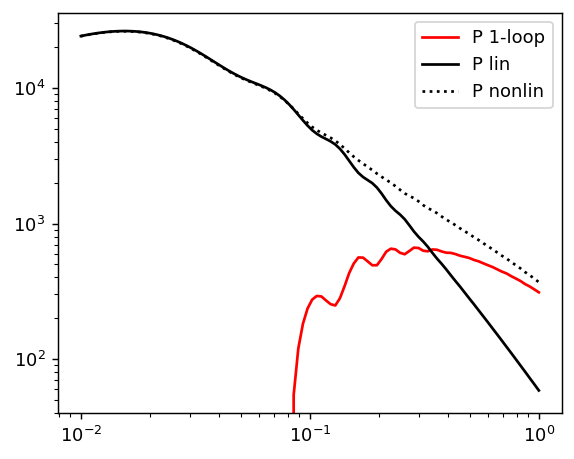

In [5]:
plt.figure(figsize=(5,4), dpi=130)

plt.plot(klist,onelterm, 'r',label=r'P 1-loop')
qq = np.logspace(-2,0,100) 

plt.plot(qq,Pchi_int(qq),'k',label=r'P lin')
plt.plot(klist,Pchi_int(klist)+onelterm,'k:',label=r'P nonlin')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

----
test FastPT

In [4]:
# import fastpt
import fastpt as fpt
from fastpt import FASTPT_simple as fpts
from fastpt.matter_power_spt import P_13_reg


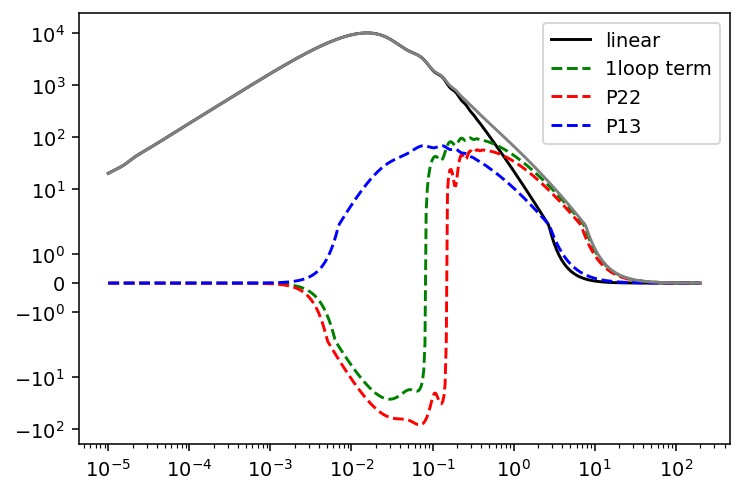

In [12]:
# from class I have kk,Pkchi
n_pad = len(kk)
fpt_obj = fpts.FASTPT(kk,-2.,n_pad=n_pad)
# Calculate the 1-loop contributions with fast-pt
P_spt = fpt_obj.one_loop(Pkchi,C_window=.75)
power, P_22 = fpt_obj.P22(Pkchi,C_window=.75)
P_13 = P_13_reg(kk,Pkchi)
# Assemble the 1-loop Pk:
P_1loop = Pkchi + P_spt
# Plot
plt.figure(figsize=(6,4), dpi=140)
plt.plot(kk,Pkchi, 'k', label='linear')
plt.plot(kk,P_spt, 'g--', label='1loop term')
plt.plot(kk,P_22, 'r--', label='P22')
plt.plot(kk,P_13, 'b--', label='P13')
plt.plot(kk, P_1loop, 'gray')
# plt.yscale('log')
plt.yscale('symlog')
plt.xscale('log')
# plt.xlim([None, 10])
plt.legend()
plt.show()